In [1]:
import numpy as np
import pickle
import sys
import os

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

sys.path.append("../dsc/functions")
import simulate
from fit_truncated_svd import truncated_svd
from fit_lowrank import rpca, nnm, nnm_sparse

sys.path.append("/gpfs/commons/home/sbanerjee/work/npd/npd-notes/notebooks/utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [4]:
n = 500
p = 1000
k = 100
Q = 3
h2 = np.random.uniform(0.2, 0.6, n)
g2 = h2 * np.random.uniform(0.1, 0.8, n)
a0 = 0.2
aq = a0 * 4
nsample = 500

Z, L, F, M, C = simulate.effect_size(n, p, k, Q, h2, g2,
                                     aq, a0, nsample,
                                     shuffle = False)
Z_cent = Z - np.mean(Z, axis = 0, keepdims = True)

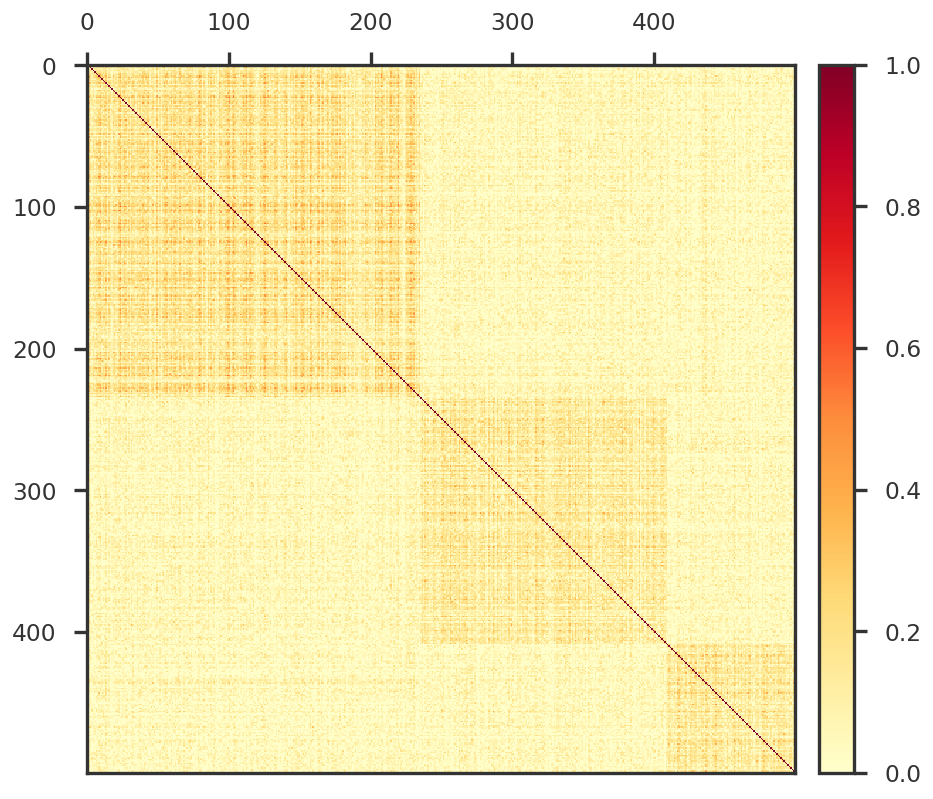

In [9]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
                                            
mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(p) / np.sqrt(nsample))
#mpy_plotfn.plot_covariance_heatmap(ax1, L * np.sqrt(k))

plt.tight_layout()
plt.show()

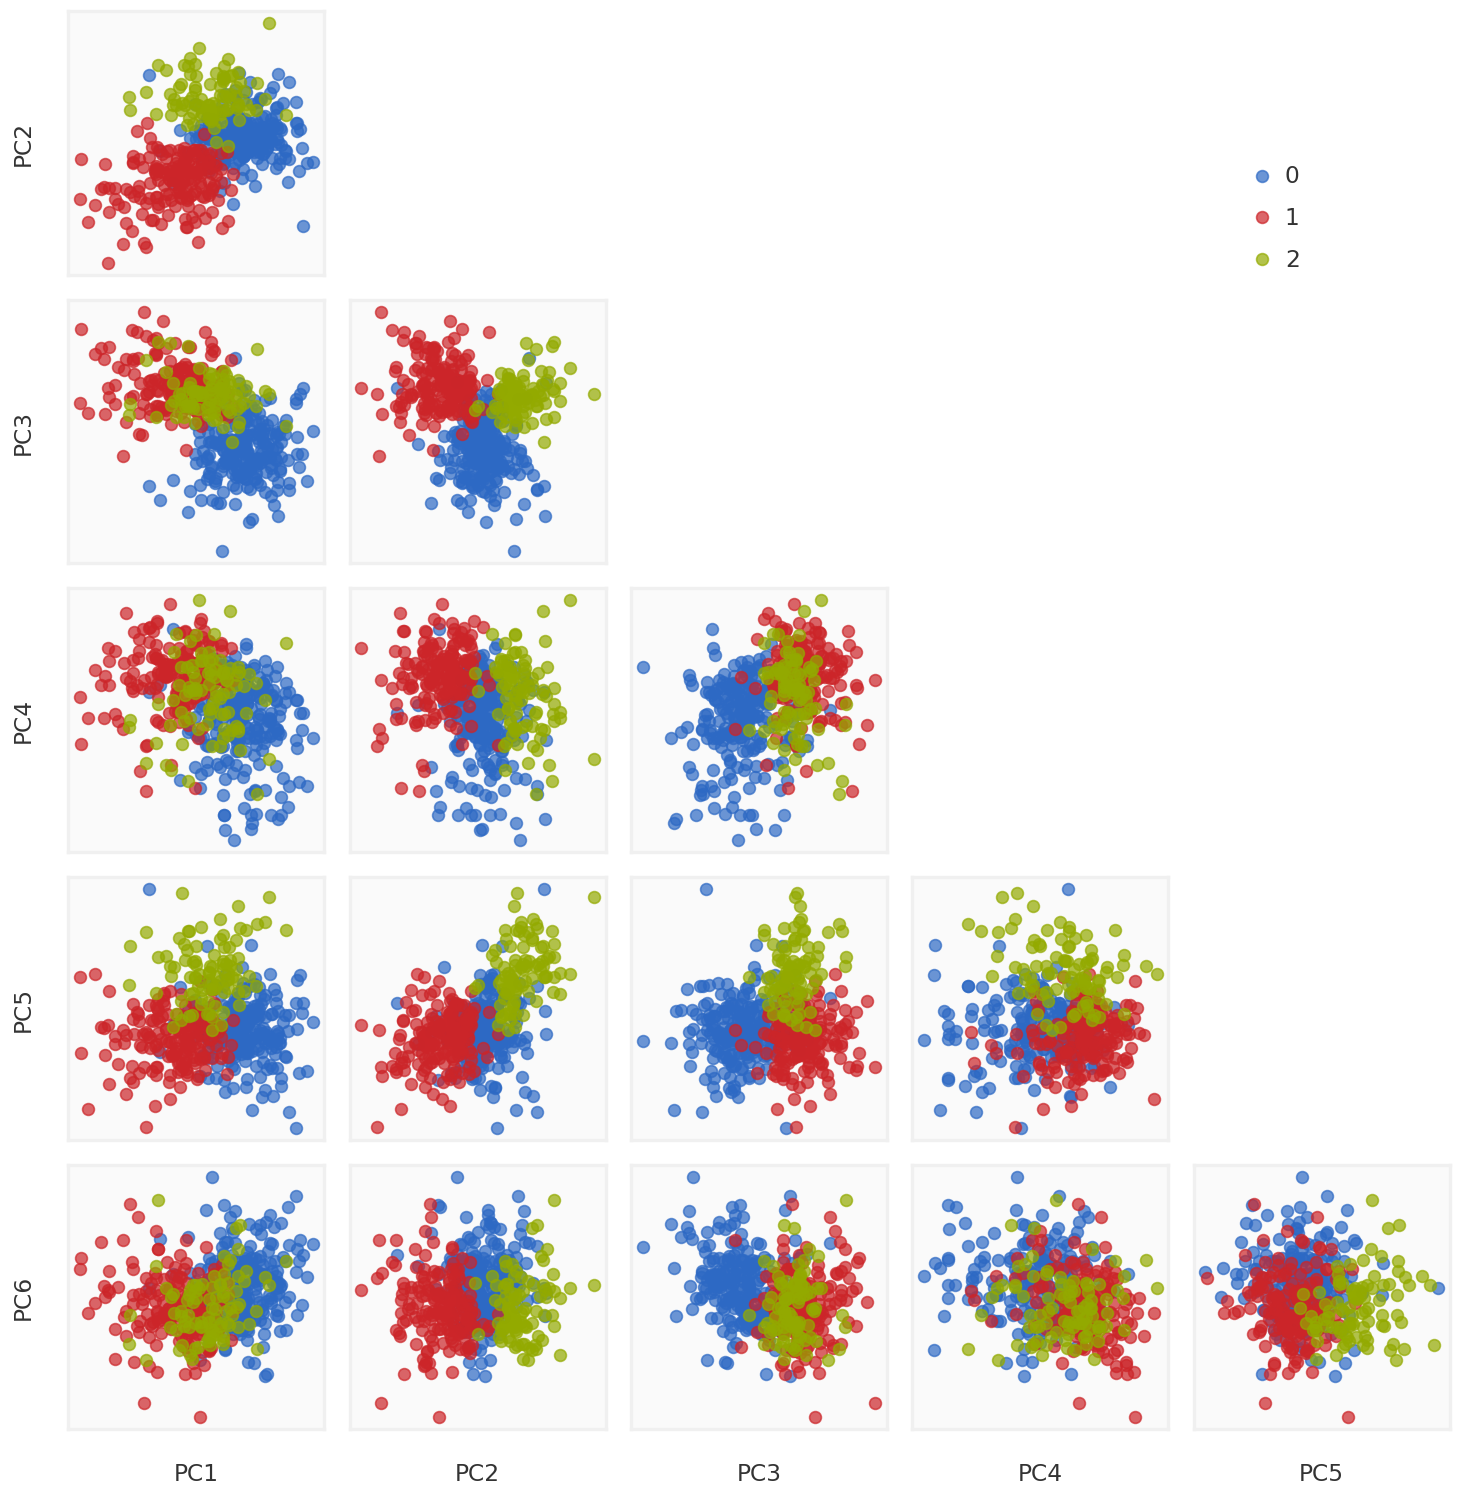

In [8]:
L_fit, F_fit, S2_fit = truncated_svd(Z, 20)

axmain, axs = mpy_plotfn.plot_principal_components(L , C, list(set(C)))
plt.show()

In [33]:
np.linalg.norm(M, ord = 1)

7.683403089665243

In [34]:
np.linalg.norm(L @ F.T, ord = 1)

6.243518860930359

In [35]:
np.linalg.matrix_rank(M)

500

In [36]:
1 / np.sqrt(np.max(Z.shape))

0.03162277660168379

In [46]:
from nnwmf.optimize import IALM
rpca_model = IALM(max_iter = 10000, mu_update_method='admm', show_progress = True, print_skip = 100)
rpca_model.fit(Z_cent)

2024-01-24 16:15:01,426 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0316)
2024-01-24 16:15:01,885 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.777842. Dual residual 0.00641347
2024-01-24 16:15:24,394 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 3.16034e-07. Dual residual 5.93543e-08


In [38]:
np.linalg.norm(rpca_model.L_, ord = 'nuc')

3987.305472844036

In [55]:
np.linalg.norm(L @ F.T, ord = 'nuc')

25.468766849242634

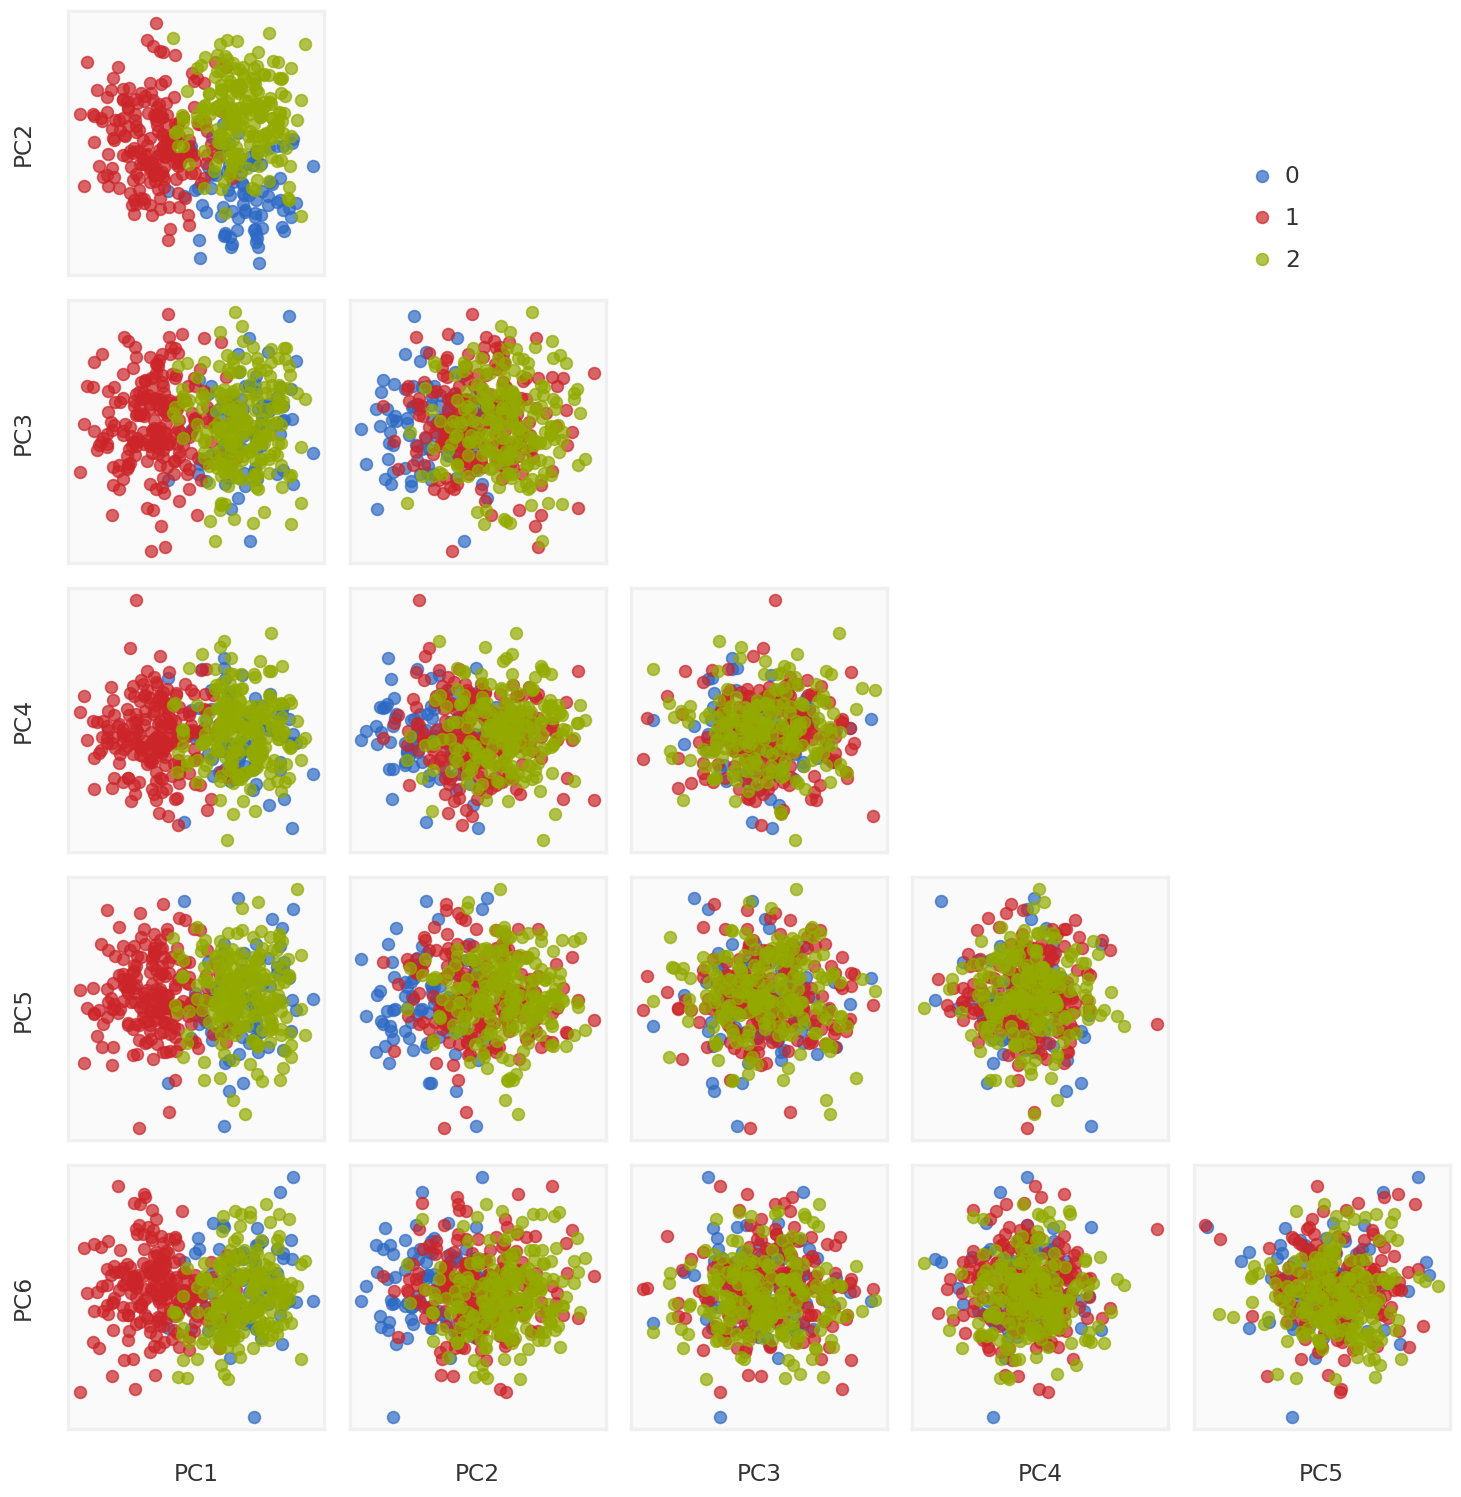

In [54]:
L_rpca, F_rpca, S2_rpca = truncated_svd(rpca_model.L_, min(Z.shape))

axmain, axs = mpy_plotfn.plot_principal_components(L_rpca, C, list(set(C)))
plt.show()

In [56]:
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
nnm_sparse_model = FrankWolfe(model = 'nnm-sparse', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm_sparse_model.fit(Z_cent, (25., 0.5))

2024-01-24 16:23:15,582 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 1654.37
2024-01-24 16:23:17,018 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:17,143 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:17,377 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:17,610 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:17,843 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:18,078 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-01-24 16:23:18,431 | nnwmf.optimize.frankwolfe                | WARN

In [60]:
nnmcv_model = FrankWolfe_CV(kfolds = 2, model = 'nnm-sparse')
nnmcv_model.fit(Z_cent)

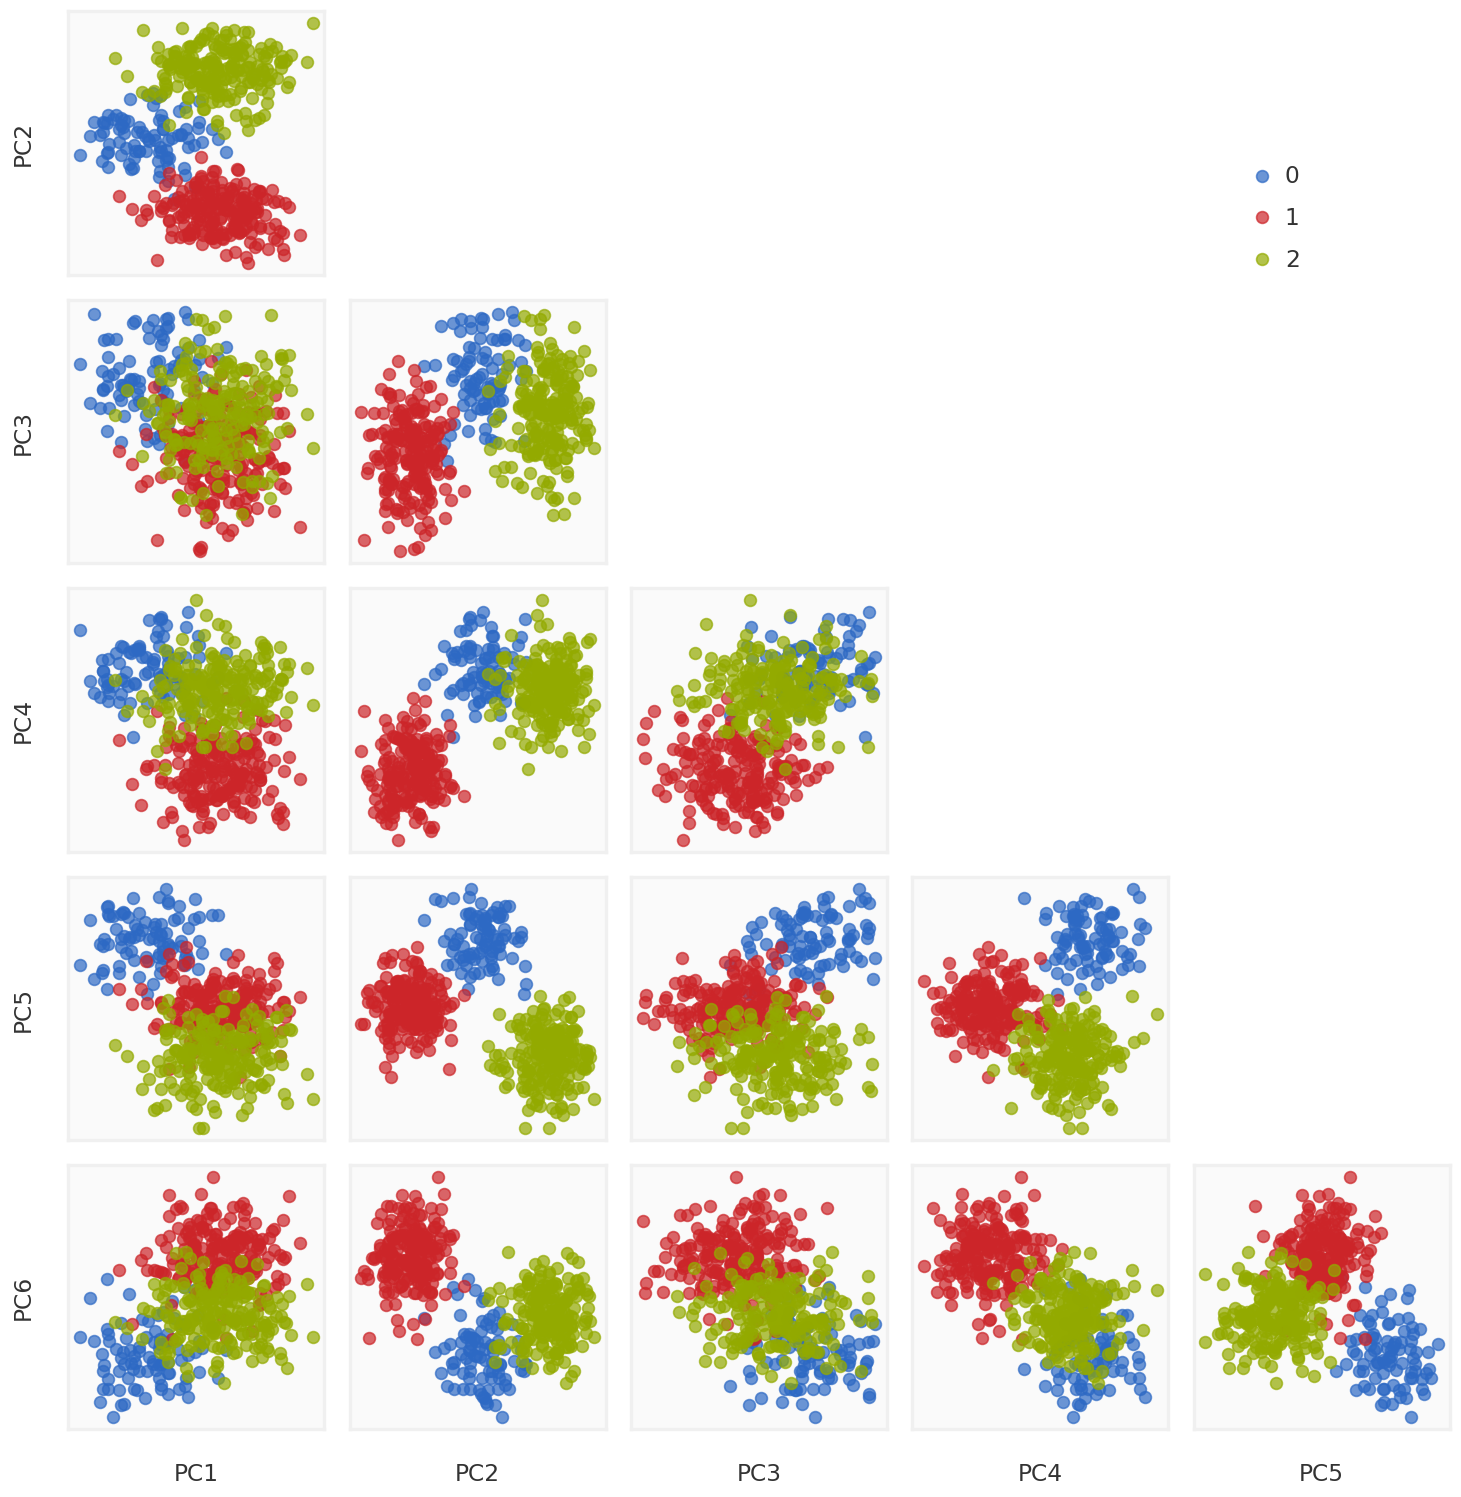

In [58]:
#Z_lowrank, _, rpca_model = rpca(Z, max_iter = 10000)
L_nnmsp, F_nnmsp, S2_nnmsp = truncated_svd(nnm_sparse_model.X, min(Z.shape))

axmain, axs = mpy_plotfn.plot_principal_components(L, C, list(set(C)))
plt.show()